# Head Velocity
Notebook for clean attempt of checking the distribution of head velocit and stimulus related behavior of the animal.

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

path = '../datasets/'
dfrat     = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')
dfevent   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
dfsession = pd.read_hdf(path+'relationalDatabase.h5', 'Sessions').set_index('index')

## Angular velocity calculations
Calculating vectors, angle, velocity for comparison.

In [2]:
pd.options.mode.chained_assignment = None 

## SMOOTHING THE DATA
windowsize = 200
colChoice = ['X_Pos', 'Y_Pos', 'Z_Pos', 'X_Ori', 'Y_Ori', 'Z_Ori']

dfV = dfrat.copy()
g = dfV.groupby('session_id')
dfV[colChoice] = g[colChoice].rolling(window=windowsize).mean().values

dfV.dropna(inplace=True)

In [3]:
# Applying the Y_Pos LPfilter
rearinglimit = 0.13
dfV = dfV[dfV['Y_Pos'] < rearinglimit]

In [4]:
# Applying the Y_Ori + Y_Pos HPfilter
halfdat = dfV.copy()
halfdat = halfdat[halfdat['Y_Ori'] < 0]
halfdat = halfdat[halfdat['Y_Ori'] >-.8]

limit = {}
for i, dd in halfdat.groupby('session_id'):
    histogram = np.histogram(dd.Y_Ori, 'auto')
    index = histogram[0].argmin()
    limit[i]= histogram[1][index] 

dfratclean = pd.DataFrame()
for i, dd in dfV.groupby('session_id'):
    dd = dd[dd['Y_Ori'] > limit[i]]
    dfratclean = pd.concat([dfratclean, dd], axis=0, ignore_index=True)

In [5]:
# ori_l = dfrat.melt(id_vars=['Frame', 'Time', 'session_id'], 
#            value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')
# ori_lSM = dfV.melt(id_vars=['Frame', 'Time', 'session_id'], 
#            value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')

In [6]:
## VECTORS WITHOUT Y
dfOri = pd.DataFrame()

for name, dd in dfratclean.groupby('session_id'):
    dd['dT'] = dd['Time'].diff(1)
    
    # calculating lenghts of VecX and VecZ and creation of shifted vectors  #dd = dd.apply(decompose_vec_df, axis=1)
    dd['lVo'] = np.linalg.norm(np.array([dd.X_Ori, dd.Y_Ori, dd.Z_Ori])  )
    dd['lx1'] = dd['X_Ori'] / dd['lVo']
    dd['lz1'] = dd['Z_Ori'] / dd['lVo']
    
    # normalize the data to unit vector form
    dd['V1'] = np.linalg.norm(np.array([dd.lx1, 0, dd.lz1]))
    dd['lx1'] = dd.lx1 / dd.V1
    dd['lz1'] = dd.lz1 / dd.V1

    dfOri = pd.concat([dfOri, dd], axis=0, ignore_index=True)

dfOri = dfOri.replace([np.inf, -np.inf], np.nan).dropna()
# print(dfOri)

In [7]:
## ANGLES and VELOCITY
dfOri2 = pd.DataFrame()

# calculatinig the angles between X axis and the vectors
for name, dd in dfOri.groupby('session_id'):
    V1 = np.array([dd.lx1, 0, dd.lz1])
    V2 = np.array([1     , 0, 0     ])
    
#   theta0 = np.arccos(lx1*1 + lz1*0 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
    dd['theta0'] = np.arccos(dd.lx1 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
    
    dd['theta1'] = dd.theta0.shift(1)
    dd['theta']  = dd.theta0 - dd.theta1
    dd.drop({'theta0','theta1'}, axis=1, inplace=True)
    
    # angular velocity between two vectors
    dd['U'] = np.degrees(dd.theta)/ dd.dT
    dd['UM'] = dd['U'].rolling(window=50).mean()
    
    dfOri2 = pd.concat([dfOri2, dd], axis=0, ignore_index=True)
    
dfOri2 = dfOri2.replace([np.inf, -np.inf], np.nan).dropna()
dfOri2 = dfOri2[np.absolute(dfOri2['dT'])<0.005]

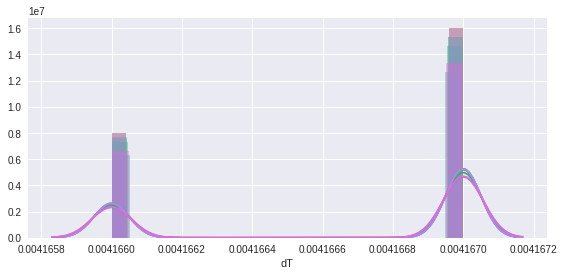

In [8]:
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'dT');

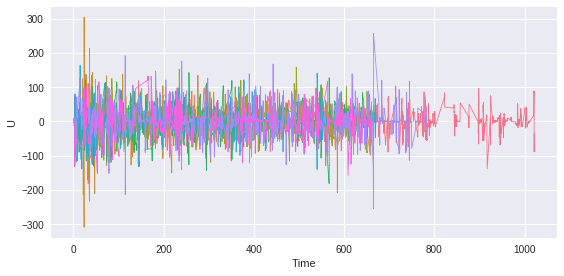

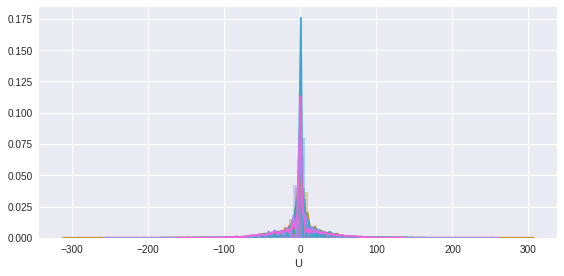

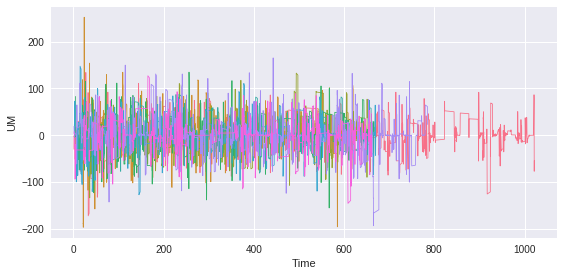

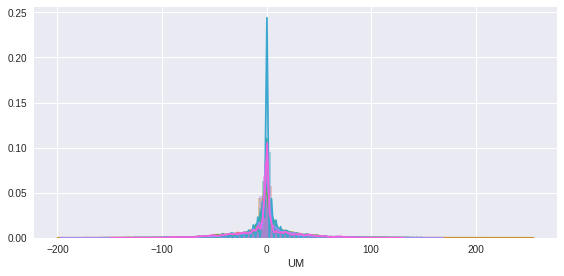

In [9]:
## ANGULAR VELOCITY IN Y AXIS
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, col_order=[0,3,4])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'U');

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'UM');


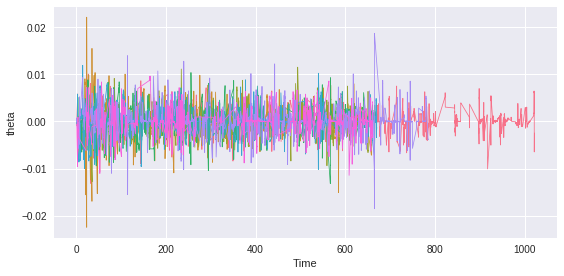

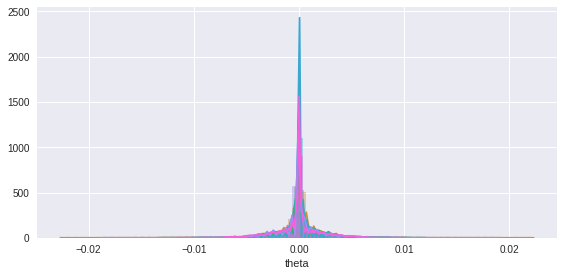

In [10]:
## THETHA CHANGE IN Y AXIS

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "theta", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'theta');


## Stimulus-related behavior
Looking for frames detected as SRB.

SRB = {f E FRAMES: ||Vhead - Vstim|| < Dmax}

In [13]:
# ## COMPARISON WITH EVENT DATA
# remove unused columns
# dfOri3 = dfOri2.drop({'lx1', 'lz1', 'V1', 'lVo', 'X_Pos', 'Y_Pos', 'Z_Pos', 'theta'}, axis=1)
dfeventsClean = dfevent.drop({'MotiveExpTimeSecs'}, axis=1)

dfV = pd.merge(dfOri2, dfeventsClean, on=['Time', 'session_id','Frame'])

In [14]:
dfV['subUM']  = dfV['speed'] - dfV['UM'] 
dfV['subU']   = dfV['speed'] - dfV['U'] 
    
dfV = dfV.replace([np.inf, -np.inf], np.nan).dropna()

In [15]:
dfV.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,session_id,X_Ori,Y_Ori,Z_Ori,dT,...,lx1,lz1,V1,theta,U,UM,visible,speed,subUM,subU
0,250,1.041667,-0.066157,0.095170,-0.055440,0,-0.811393,-0.015122,-0.450515,0.004167,...,-0.874276,-0.485430,0.003000,-0.000926,-12.736846,-29.882999,0,0.0,29.882999,12.736846
1,251,1.045833,-0.066115,0.095079,-0.055584,0,-0.809845,-0.018051,-0.450609,0.004166,...,-0.873839,-0.486216,0.002996,-0.000899,-12.370895,-29.387920,0,0.0,29.387920,12.370895
2,252,1.050000,-0.066075,0.094983,-0.055727,0,-0.808316,-0.021087,-0.450666,0.004167,...,-0.873422,-0.486965,0.002992,-0.000857,-11.782403,-28.898740,0,0.0,28.898740,11.782403
3,253,1.054167,-0.066038,0.094882,-0.055867,0,-0.806807,-0.024181,-0.450679,0.004167,...,-0.873028,-0.487670,0.002987,-0.000807,-11.100431,-28.378518,0,0.0,28.378518,11.100431
4,254,1.058333,-0.066002,0.094778,-0.056006,0,-0.805321,-0.027345,-0.450644,0.004166,...,-0.872661,-0.488326,0.002983,-0.000752,-10.346144,-27.858187,0,0.0,27.858187,10.346144


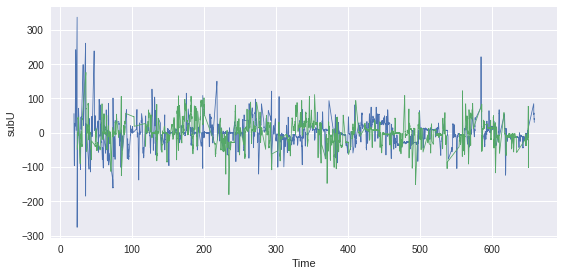

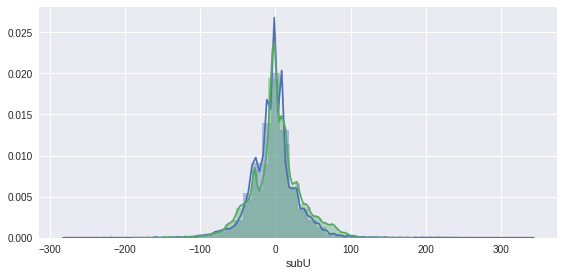

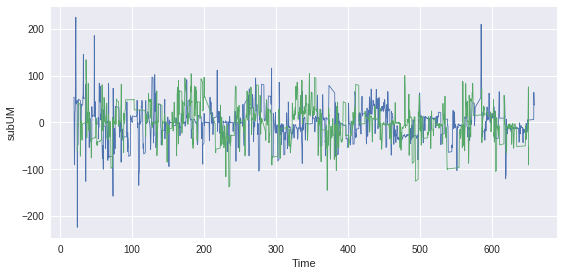

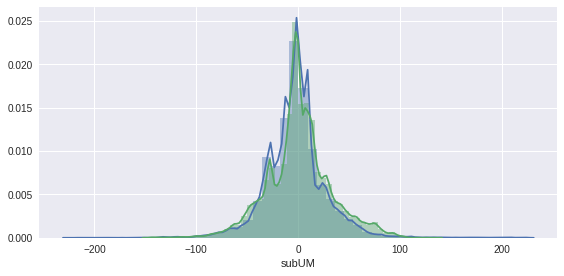

In [16]:
## ANGULAR VELOCITY IN Y AXIS

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subU');

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subUM');


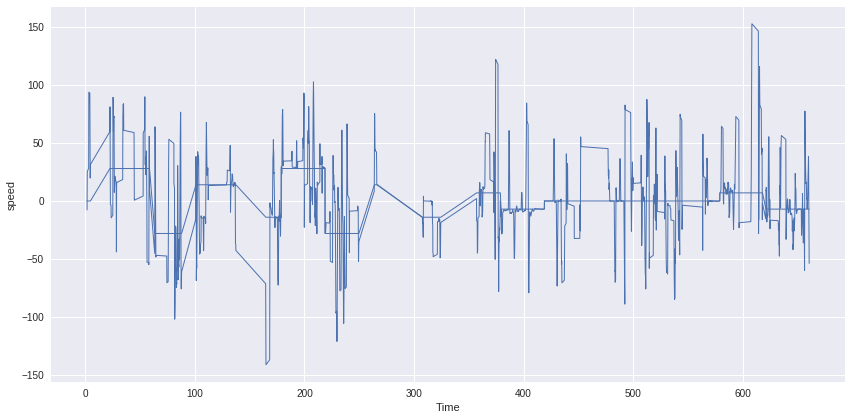

In [17]:
i = 7
g = sns.FacetGrid(data=dfV[dfV['session_id']==i], size=6, aspect=2)
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);


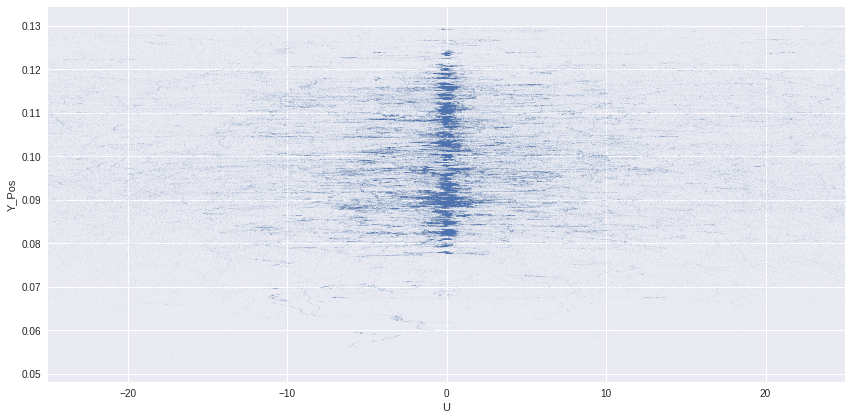

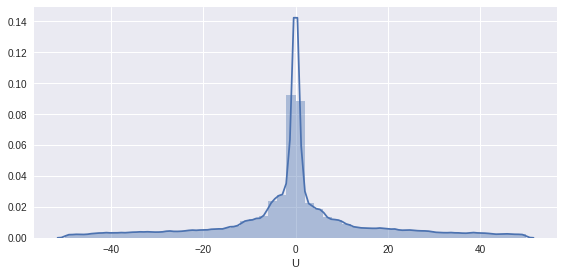

In [26]:

g = sns.FacetGrid( data=dfV, size=6, aspect=2, xlim=[-25,25])
g.map(plt.scatter,'U', "Y_Pos", alpha=0.1, s=0.1);

g = sns.FacetGrid( data=dfV[np.absolute(dfV['U'])<50], size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'U');


In [27]:
# setting Dmax as 20% of velocity at given moment // what about 0
DmaxPerc = 0.2
dfV['Dmax'] = dfV.speed * DmaxPerc
# dfV['Dmax'] = lambda dfV: 0.1 if dfV.Dmax == 0 else dfV.Dmax

dfV['SRB_UM']  = np.absolute(dfV['subUM'].values)  < np.absolute(dfV['Dmax'].values)
sumFrame = len(dfV.Frame)

# checking lenght of SRB frames in the filtered experiment data
SRB_UM = dfV[dfV['SRB_UM']]
sumSRB_UM = len(SRB_UM)
print('stimulus-related behavior UM : %f%%' % (sumSRB_UM  * 100 / sumFrame))

## SRB PER EXPERIMENT
sumFrameexp   = {}
sumSRBexp_UM  = {}

for i, dd in dfV.groupby('session_id'):
    sumFrameexp[i] = len(dd.Frame)    
    sumSRBexp_UM[i]  = len(dd[dd['SRB_UM']])
    
    print('stimulus-related behavior exp %d UM : %f%%'  % (i, sumSRBexp_UM[i]  * 100 / sumFrameexp[i]))


stimulus-related behavior UM : 3.731299%
stimulus-related behavior exp 0 UM : 3.366367%
stimulus-related behavior exp 1 UM : 2.795068%
stimulus-related behavior exp 2 UM : 5.315298%
stimulus-related behavior exp 3 UM : 3.587143%
stimulus-related behavior exp 4 UM : 5.409423%
stimulus-related behavior exp 5 UM : 2.373360%
stimulus-related behavior exp 6 UM : 4.652229%
stimulus-related behavior exp 7 UM : 2.749184%


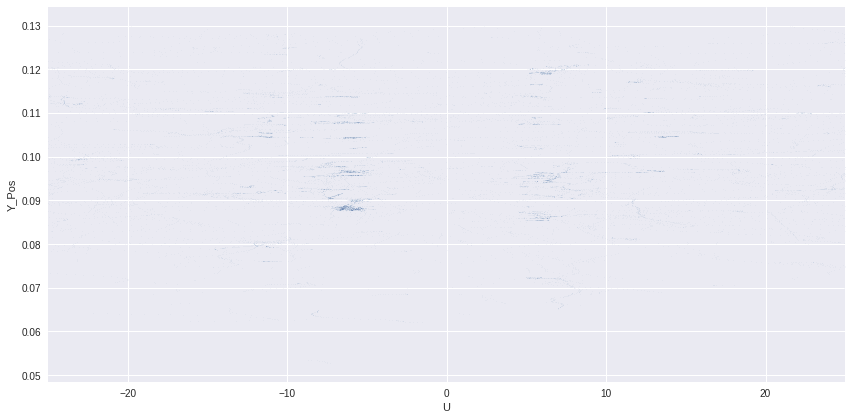

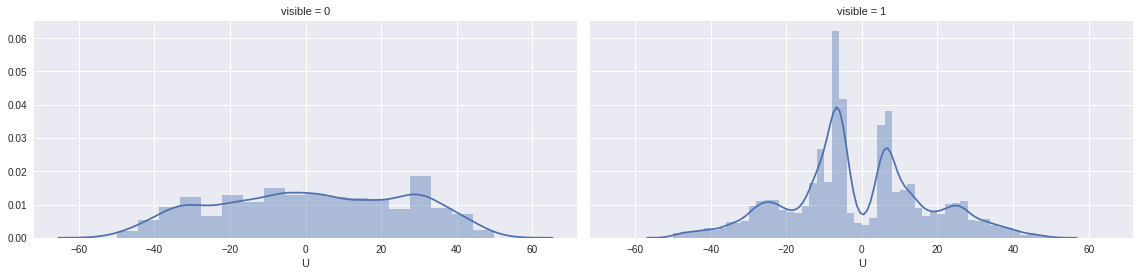

In [32]:
g = sns.FacetGrid( data=dfV[dfV['SRB_UM']], size=6, aspect=2, xlim=[-25,25])
g.map(plt.scatter,'U', "Y_Pos", alpha=0.1, s=0.1);

g = sns.FacetGrid( data=dfV[(dfV['SRB_UM']) & (np.absolute(dfV['U'])<50)], col='visible', size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'U');
# g.map(sns.distplot, 'speed');
